<a href="https://colab.research.google.com/github/IsaacFigNewton/Text-to-Timeline/blob/main/Event_DAG_parsing_with_SpaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download NLP packages

In [1]:
# Broken libraries I've tried: AllenNLP, Coreferee, neuralcoref, spacy-experimental, stanford-corenlp (only api available)
# Maybe try for NER: Flair

In [2]:
!pip install fastcoref

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
  

# Config
[fastcoref](https://pypi.org/project/fastcoref/)

In [3]:
import json
import spacy
from fastcoref import FCoref, spacy_component

In [4]:
default_nlp_model = spacy.load("en_core_web_sm")
# Merge noun phrases and entities for easier analysis
# nlp.add_pipe("merge_entities")
# nlp.add_pipe("merge_noun_chunks")

fastcoref_model = FCoref()

coref_resolution_model = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
coref_resolution_model.add_pipe("fastcoref")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

In [5]:
def get_subtree_text(token):
  lefts = [get_subtree_text(t) for t in token.lefts]
  rights = [get_subtree_text(t) for t in token.rights]
  tokens_in_subtree = lefts + [token.text] + rights
  return " ".join(tokens_in_subtree)

## Keywords

In [6]:
time_nouns = {
    "start",
    "beginning",
    "end",
    "duration",
    "time",
}

In [7]:
pronouns = {
    "it": {
        "category": "neutral",
        "role": "object",
        "number": "singular"
    },
    "its": {
        "category": "neutral",
        "role": "possessive",
        "number": "singular"
    },
    "this": {
        "category": "neutral",
        "role": "subject",
        "number": "singular"
    },
    "these": {
        "category": "neutral",
        "role": "subject",
        "number": "plural"
    },
    "that": {
        "category": "neutral",
        "role": "object",
        "number": "singular"
    },
    "those": {
        "category": "neutral",
        "role": "object",
        "number": "plural"
    },
    "I": {
        "category": "first_person",
        "role": "subject",
        "number": "singular"
    },
    "we": {
        "category": "first_person",
        "role": "subject",
        "number": "plural"
    },
    "me": {
        "category": "first_person",
        "role": "object",
        "number": "singular"
    },
    "us": {
        "category": "first_person",
        "role": "object",
        "number": "plural"
    },
    "my": {
        "category": "first_person",
        "role": "possessive",
        "number": "singular"
    },
    "mine": {
        "category": "first_person",
        "role": "possessive",
        "number": "singular"
    },
    "ours": {
        "category": "first_person",
        "role": "possessive",
        "number": "plural"
    },
    "our": {
        "category": "first_person",
        "role": "possessive",
        "number": "plural"
    },
    "you": {
        "category": "second_person",
        "role": "object",
        "number": "plural"
    },
    "yours": {
        "category": "second_person",
        "role": "possessive",
        "number": "plural"
    },
    "your": {
        "category": "second_person",
        "role": "possessive",
        "number": "plural"
    },
    "she": {
        "category": "third_person",
        "role": "subject",
        "number": "singular"
    },
    "he": {
        "category": "third_person",
        "role": "subject",
        "number": "singular"
    },
    "they": {
        "category": "third_person",
        "role": "subject",
        "number": "plural"
    },
    "her": {
        "category": "third_person",
        "role": "possessive",
        "number": "singular"
    },
    "him": {
        "category": "third_person",
        "role": "object",
        "number": "singular"
    },
    "them": {
        "category": "third_person",
        "role": "object",
        "number": "plural"
    },
    "his": {
        "category": "third_person",
        "role": "possessive",
        "number": "singular"
    },
    "hers": {
        "category": "third_person",
        "role": "possessive",
        "number": "singular"
    },
    "their": {
        "category": "third_person",
        "role": "possessive",
        "number": "plural"
    },
    "theirs": {
        "category": "third_person",
        "role": "possessive",
        "number": "plural"
    }
}

## Simplify Clause Structure

In [8]:
def simplify_clause_structure(doc):
  roots = list()
  for token in doc:
    if token.dep_ == "ROOT":
      roots.append(token)

  simplified_text = ""
  for root in roots:
    primary_clause = list()
    secondary_clause = list()

    for child in root.rights:
      # if there's an advanced clause that comes before this one, mark it as such
      if child.dep_ == "advcl":
        print(child.text)
        # if the token isn't the head of an advanced clause
        #   and it's not a temporal marker,
        #   add the token's subtree to the primary clause's text
        primary_clause = [get_subtree_text(child_child)\
                            for child_child in child.lefts\
                            if not (
                                (child_child.pos_ == "SCONJ")
                          )]
        primary_clause += [child.text]
        primary_clause += [get_subtree_text(child_child)\
                            for child_child in child.rights]


    # add the text to the left of the root
    secondary_clause += [get_subtree_text(l) for l in root.lefts]
    secondary_clause += [root.text]
    secondary_clause += [get_subtree_text(r) for r in root.rights if r.dep_ != "advcl"]

    # combine the segmented clauses
    simplified_text += " ".join(primary_clause + ["."] + secondary_clause)

  return default_nlp_model(simplified_text)

## FastCoref helper functions

In [9]:
def get_replacements(d: dict) -> dict:
  replacements = list()
  # get a list of the intervals, their sizes, and replacements for each disambiguated referent cluster
  span_replacements = [(i, placeholder) for placeholder, intervals in d.items() for i in intervals]

  # sort the list of intervals by start and end
  span_replacements = sorted(span_replacements, key=lambda x: x[0])

  i = 0
  while i < len(span_replacements):
    # if the end of the list is reached
    if i + 1 == len(span_replacements):
        replacements.append(span_replacements[i])

    # if the next one DOESN'T have the same start position
    elif span_replacements[i][0][0] != span_replacements[i + 1][0][0]:
        replacements.append(span_replacements[i])

    # since span_replacements is sorted by start, end,
    #   (start1 == start2) ==> start2 will always be larger
    i += 1

  return replacements

In [10]:
def get_cluster_matches(text:str,
                     replacements: list,
                     model = default_nlp_model) -> dict:
  """
  returns a dict:
    keys correspond to the placeholder entities in the text
    values are lists of tuples
      tuple[0] = start index of the match in the original text
      tuple[1] = end index of the match in the original text
      tuple[2] = cluster text
  """

  # rebuild cluster dict
  cluster_labels = {c[1] for c in replacements}
  clusters = {c: list() for c in cluster_labels}

  for i, r in replacements:
    clusters[r].append((
      i[0],
      i[1],
      text[i[0]:i[1]]
    ))

  return clusters

In [11]:
def replace_clusters(text:str,
                     replacements: list,
                     model = default_nlp_model) -> str:

  new_text = list()
  s = 0
  for i, r in replacements:
    new_text.append(text[s:i[0]])
    new_text.append(r)
    s = i[1]

  new_text.append(text[s:])
  return "".join(new_text)

## FastCoref Disambiguation

In [12]:
def resolve_text(text:str):
  doc = coref_resolution_model(
    text,
    component_cfg={"fastcoref": {'resolve_text': True}}
  )

  return doc._.resolved_text

In [13]:
def disambiguate_refs(text:str,
                      base_model = default_nlp_model):

  doc = base_model(text)

  preds = fastcoref_model.predict(texts=[text])

  # get disambiguated clusters
  clusters = {f"E{i}": clusters for i, clusters in enumerate(preds[0].get_clusters(as_strings=False))}
  # restructure the clusters dict for replacement
  replacements = get_replacements(clusters)
  # replace the cluster matches
  cluster_strings = get_cluster_matches(
    text,
    replacements
  )
  ambiguated_text = replace_clusters(
    text,
    replacements
  )

  return cluster_strings, ambiguated_text

## Ambiguation

In [14]:
def ambiguate_text(text:str):
  resolved_text = resolve_text(text)
  return disambiguate_refs(
    text=resolved_text,
    base_model = default_nlp_model
  )

## Subj - pred - obj triple extraction

In [15]:
from spacy.symbols import nsubj, VERB, AUX, ADJ

In [16]:
def get_prep_obj_from_prep_branch(token, obj_pos_tags:set):
    # get the preposition-object substructure
    for child in token.children:
      if child.dep_ == "prep":
        for child_child in child.children:
          if child_child.dep_ in obj_pos_tags:
            return child.text, child_child.text
    return None, None

In [17]:
def get_subj_from_conj(token):
  for child in token.children:
    if child.dep_ == "nsubj":
      return child.text
  return None

In [18]:
def get_subj_dobj(verb_root, suffix:str):
  ind_obj_nodes = list()
  edges = list()
  obj_pos_tags = {"dobj", "pobj", "iobj"}

  # for each left child of the verb root
  subj = None
  for token in verb_root.lefts:
    # if it's a subject, set the subject as such
    if token.dep_ == "nsubj":
      subj = get_subtree_text(token)
      break

  pred = verb_root.text
  obj = None
  # for each right child of the verb root
  for token in verb_root.rights:
    # if it's a direct object, return
    if token.dep_ in obj_pos_tags:
      obj = get_subtree_text(token)
      break

    # if it's an adjective complement phrase
    elif token.dep_ == "acomp":

      # check if the complement phrase has an object as one of its children
      has_obj = False
      for child in token.children:
        if child.dep_ in obj_pos_tags:
          # if there's no object in the children of this token
          has_obj = True
          # set the object
          obj = get_subtree_text(child)
          break

      # if this is an intermediate token, such as an adjective, but no object
      if not has_obj:
        # combine the children of this node, as well as the old root,
        #   into a predicate phrase
        left_mods = " ".join([t.text for t in token.lefts])
        # right_mods = " ".join([t.text for t in token.rights])
        # pred = f"{verb_root.text} {left_mods} {token.text} {right_mods}"
        # obj = get_prep_obj_from_prep_branch(token, obj_pos_tags)
        pred = f"{verb_root.text} {left_mods}"
        obj = get_subtree_text(token)

      # add the indirect object node to the list of nodes
      ind_obj_nodes.append(obj)
      break

    # if it's a complement phrase
    elif token.dep_ == "ccomp":

      # use a placeholder for the indirect object
      obj = f"INDOBJ_{suffix}"
      edges.append((subj, pred, obj))

      # add the indirect object node to the list of nodes
      ind_obj_nodes.append(obj)

      # recurse on the complement phrase
      comp_nodes, comp_edges = get_subj_dobj(
          token,
          str(len(ind_obj_nodes))
      )

      # the first edge will always be between the local subject and obj/ind-obj
      nested_subj = comp_edges[0][0]
      nested_obj = comp_edges[0][2]

      # add edges to indicate the indirect object's relation to the nested subject and object
      edges.append((obj, "subject", nested_subj))
      edges.append((obj, "object", nested_obj))

      # add the nodes and edges to the associated lists
      ind_obj_nodes = ind_obj_nodes + comp_nodes
      edges = edges + comp_edges
      break

  # if a subject is missing, check to see if this is a conjugate phrase
  if not subj and verb_root.dep_ == "conj":
    # if it is, check the parent phrase for a subject, and use that
    subj = get_subj_from_conj(verb_root.head)

  # if no object was found, then it's probably hidden under a preposition branch
  if not obj:
    prep_addition, obj = get_prep_obj_from_prep_branch(verb_root, obj_pos_tags)
    pred = f"{pred} {prep_addition}" if prep_addition else pred

  edges.append((subj, pred, obj))

  return ind_obj_nodes, edges

In [19]:
def get_edges(doc):
  edges = list()
  ind_obj_nodes = list()
  verb_roots_checked = set()

  # for each noun chunk
  for chunk in doc.noun_chunks:
      head = chunk.root.head

      if head.text not in verb_roots_checked:

        # if the  parent of the noun chunk is a verb
        if head.pos in {VERB, AUX}:

            # recurse on the children of the verb root
            comp_nodes, comp_edges = get_subj_dobj(
                head,
                str(len(ind_obj_nodes))
            )

            # add the nodes and edges to the associated lists
            ind_obj_nodes = ind_obj_nodes + comp_nodes
            edges = edges + comp_edges

            verb_roots_checked.add(head.text)

  return edges

## Get inter-cluster edges, put it all together

In [20]:
def get_referent_from_cluster(cluster_members):
  return max(cluster_members, key=len)

In [21]:
def get_inter_cluster_edges(edges:list, clusters:dict) -> list:

  # get a list of nodes that have the word "and" in them
  nodes = set()
  for e in edges:
    if e[0] not in nodes\
      and "and" in e[0].split(" "):
      nodes.add(e[0])
    if e[2] not in nodes\
      and "and" in e[0].split(" "):
      nodes.add(e[2])

  # for each node, split on " and "
  for node in nodes:
    members = node.split(" and ")
    for m in members:
      for c_key, c_members in clusters.items():
        # if a member is in a given cluster,
        if m in c_members:
          edges.append((
              get_referent_from_cluster(c_members),
              "member of",
              node
          ))

  return edges

In [22]:
def get_text_info_json(text:str):
  doc_info = dict()

  doc = default_nlp_model(text)

  # restructure the text to simplify the clause structure
  doc_info["restructured"] = simplify_clause_structure(doc)
  # get clusters, ambiguated text
  cluster_matches, ambiguated_text = ambiguate_text(text)
  doc_info["cluster_matches"] = cluster_matches
  doc_info["ambiguated"] = ambiguated_text

  doc = default_nlp_model(ambiguated_text)

  # get an edge list based on the ambiguated elements
  edges = get_edges(doc_info["restructured"])
  doc_info["edges"] = list()
  # resolve references in the edges based on the longest element of the cluster
  for e in edges:

    e_new = e
    if e[0] in cluster_matches:
      cluster = cluster_matches[e_new[0]]
      longest_string = get_referent_from_cluster(cluster)
      e_new = (longest_string, e_new[1], e_new[2])

    if e[2] in cluster_matches:
      cluster = cluster_matches[e_new[2]]
      longest_string = get_referent_from_cluster(cluster)
      e_new = (e_new[0], e_new[1], longest_string)

    doc_info["edges"].append(e_new)


  # shift edge labels to lower case
  doc_info["edges"] = [
      (
        e[0].lower(),
        e[1].lower(),
        e[2].lower(),
      ) for e in doc_info["edges"]
  ]

  # get the sequence of events in the text
  events = {e for e in doc_info["edges"] if ("INDOBJ_" not in e[0])}
  doc_info["event_seq"] = list()
  for e in events:
    for i, edge in enumerate(doc_info["edges"]):
      if e == edge and e not in doc_info["event_seq"]:
        doc_info["event_seq"].insert(i, e)

  # get inter-cluster edges, for groups of entities
  doc_info["edges"] += get_inter_cluster_edges(
      doc_info["edges"],
      cluster_matches
  )

  return doc_info

# Test it all together

In [23]:
def run_tests(texts:str):
  ambiguated_texts = [[t, None] for t in texts]
  ambiguated_test = None

  for i in range(len(texts)):
    _, ambiguated_test = ambiguate_text(texts[i])
    ambiguated_texts[i][1] = ambiguated_test

  for test in ambiguated_texts:
    print(f"original:\n{test[0]}")
    print(f"disambiguated:\n{test[1]}")
    # print()

## Run Tests

In [24]:
tests = [
    "The frog jumped over the goose. Mr. Holmes is gay. Then the frog fell into the abyss. The goose followed the frog into the abyss and after that ate a different frog.",
    "Although he was very busy with his work, Peter had had enough of it. He and his wife decided they needed a holiday. They travelled to Spain because they loved the country very much.",
    "John met Paul after he finished work. He suggested they grab a drink.",
    "The book was on the table when Sarah handed it to Mary. She smiled and thanked her.",
    "Tom told Jerry that he had failed the exam.",
    "The city council refused the demonstrators a permit because they feared violence.",
    "Anna told Lucy that her idea was brilliant.",
    "The scientist interviewed the assistant while she was setting up the experiment.",
    "After the dog bit the man, he ran away.",
    "The mechanic fixed the car while it was raining. He was soaked by the end.",
    "David thanked Michael after his birthday party.",
    "Karen lent her book to Julie because she needed it for class."
]

In [25]:
# run_tests(tests)

## Test pipeline

In [26]:
test_0 = get_text_info_json(tests[0])
test_0

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

{'restructured': . The frog jumped over the goose .. Mr. Holmes is gay .. Then the frog fell into the abyss .. The goose followed the frog into the abyss and after that ate a different frog .,
 'cluster_matches': {'E1': [(21, 30, 'the goose'), (86, 95, 'the goose')],
  'E2': [(75, 84, 'the abyss'), (119, 128, 'the abyss')],
  'E0': [(0, 8, 'The frog'), (56, 64, 'The frog'), (105, 113, 'The frog')]},
 'ambiguated': 'E0 jumped over E1. Mr. Holmes is gay. Then E0 fell into E2. E1 followed E0 into E2 and after that ate a different frog.',
 'edges': [('the frog', 'jumped over', 'goose'),
  ('mr. holmes', 'is ', 'gay'),
  ('the frog', 'fell into', 'abyss'),
  ('the goose', 'followed', 'the frog'),
  ('goose', 'ate', 'a different frog'),
  ('the frog', 'jumped over', 'goose'),
  ('mr. holmes', 'is ', 'gay'),
  ('the frog', 'fell into', 'abyss'),
  ('the goose', 'followed', 'the frog'),
  ('goose', 'ate', 'a different frog')],
 'event_seq': [('the frog', 'jumped over', 'goose'),
  ('mr. holmes

<ipython-input-27-867f8d745e46>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


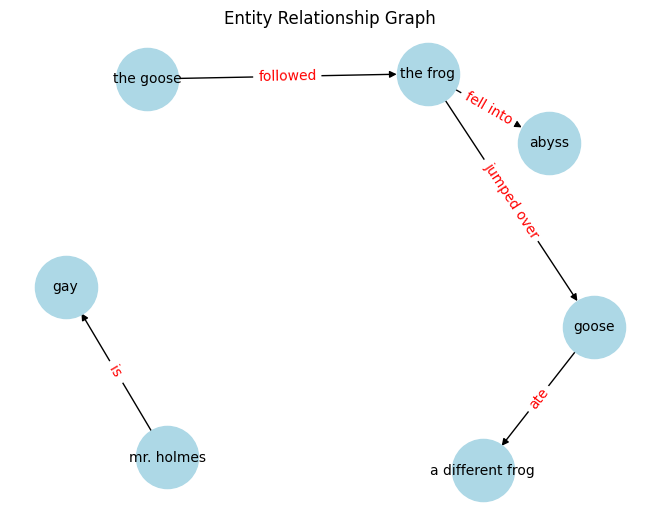

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with predicate as edge label
for subj, pred, obj in test_0["edges"]:
    G.add_edge(subj, obj, label=pred)

# Draw the graph
pos = nx.spring_layout(G,  k=2,)  # or try nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10, arrows=True)

# Draw edge labels (predicates)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Entity Relationship Graph")
plt.tight_layout()
plt.show()
